In [106]:
import import_ipynb
from ConsistencyIndexes import *
import torch.nn.functional as Fun
import torch
from torch import optim
import matplotlib.pyplot as plt
import time

In [107]:
#Extract kernels and weights from Parameters
def Extract(Params):
    k = Params['k']
    kt = Params['kt']
    kb = Params['kb']
    return k,kt,kb

In [108]:
def Gen_Params(N):
    # Current
    k = [torch.rand(3,3,k_size,k_size,requires_grad=True) for k_size in range(3,4,12)]     
    # Kernels for Temporal Consistency
    kt = [[torch.rand(3,3,k_size,k_size,requires_grad=True) for k_size in range(3,4,12)]  for _ in range(2*N)]
    kb = [torch.rand(3,3,k_size,k_size,requires_grad=True) for k_size in range(3,4,12)]
    return k,kt,kb

In [109]:
def ObjFun(encodes,x,k,kt,kb):
    N = len(kt)
    N_k = len(k[0])
    encodes = encodes[:N//2]+encodes[N//2+1:]
    # Encoder
    for i in k:
        sp = i.shape[-1]//2
        x = Fun.leaky_relu(Fun.conv2d(x,i,stride=1,padding=sp))
    # Temporal Encoder
    for i in range(len(encodes)):
         for j in kt[i]:  
            sp = j.shape[-1]//2
            encodes[i] = Fun.leaky_relu(Fun.conv2d(encodes[i],j,stride=1,padding=sp))
            
    # Add latent values
    for i in range(len(encodes)):
        x = x + encodes[i]
    
    for i in kb:
        sp = i.shape[-1]//2
        x = Fun.leaky_relu(Fun.conv2d(x,i,stride=1,padding=sp))
        
    return x

In [110]:
#Add a random inconsistency
def AddOneInc1(F):
    # Convert to NumPy Array
    F = F.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255
    # Copy of original array
    I = F.astype(np.uint8).copy()
    # Random location
    x, y = random.randint(0, 2 * I.shape[0] // 3), random.randint(0, 2 * I.shape[1] // 3)
    # Random size
    l = random.randint(5,I.shape[1]//20)
    # Random option
    Op = random.randint(0, 5)
    if Op == 0:
        I[x:x + l, y:y + l] = change_range_colors(I[x:x + l, y:y + l], (random.randint(30, 140), random.randint(30, 140), random.randint(30, 140)), (random.randint(150, 255), random.randint(150, 255), random.randint(150, 255)))
    elif Op == 1:
        R, G, B = random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)
        I[x:x + l, y:y + l] = change_range_colors(I[x:x + l, y:y + l], (R, G, B), (R, G, B))
    elif Op == 2:
        Thick = random.randint(1, 10)
        l2 = random.randint(5, I.shape[1]//15)
        I = cv2.line(I, (x, y), (x + l, y + l2), (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), Thick)
    elif Op == 3:
        Thick = random.randint(1, 5)
        l2 = random.randint(5, I.shape[1]//20)
        I = cv2.line(I, (x, y), (x + l, y + l2), (0, 0, 0), Thick)  
    elif Op == 4:
        I[x:x+l,y:y+l] = I[x:x+l,y:y+l] + np.random.random_integers(-10,10,I[x:x+l,y:y+l].shape)
    else:
        kernel = np.random.rand(3,3)
        I[x:x+l,y:y+l] = cv2.filter2D(I[x:x+l,y:y+l],-1,kernel)
    # Convert back to tensor
    I_tensor = torch.tensor(I, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)/255.0
    return I_tensor

In [111]:
def OF(img1: torch.Tensor, img2: torch.Tensor, alpha: float = 1.0, iterations: int = 100):
    assert img1.shape == img2.shape, "Images must have the same shape"
    # Convert to grayscale to simplify optical flow calculation
    def rgb_to_grayscale(img):
        return 0.2989 * img[0, :, :] + 0.5870 * img[1, :, :] + 0.1140 * img[2, :, :]

    I1 = rgb_to_grayscale(img1)
    I2 = rgb_to_grayscale(img2)

    # Initialize optical flow vectors (u for x direction, v for y direction)
    u = torch.zeros_like(I1, requires_grad=True)
    v = torch.zeros_like(I1, requires_grad=True)
    
    # Define convolution kernels for gradients
    kernel_x = torch.tensor([[[[-1, 1], [-1, 1]]]], dtype=torch.float32)
    kernel_y = torch.tensor([[[[-1, -1], [1, 1]]]], dtype=torch.float32)

    # Compute gradients with padding that maintains the original image size
    Ix = Fun.conv2d(I1.unsqueeze(0).unsqueeze(0), kernel_x, padding=(0, 1)).squeeze(0).squeeze(0)
    Iy = Fun.conv2d(I1.unsqueeze(0).unsqueeze(0), kernel_y, padding=(1, 0)).squeeze(0).squeeze(0)
    It = I2 - I1  # Temporal gradient

    # Ensure all tensors have matching dimensions by cropping to the smallest dimensions
    min_h = min(Ix.shape[-2], Iy.shape[-2], It.shape[-2], I1.shape[-2])
    min_w = min(Ix.shape[-1], Iy.shape[-1], It.shape[-1], I1.shape[-1])

    # No additional indexing needed here
    Ix = Ix[:min_h, :min_w]
    Iy = Iy[:min_h, :min_w]
    It = It[:min_h, :min_w]
    u = u[:min_h, :min_w]
    v = v[:min_h, :min_w]

    # Iteratively update the optical flow
    for _ in range(iterations):
        # Average flow in the neighborhood
        u_avg = Fun.avg_pool2d(u.unsqueeze(0).unsqueeze(0), 3, stride=1, padding=1).squeeze(0).squeeze(0)
        v_avg = Fun.avg_pool2d(v.unsqueeze(0).unsqueeze(0), 3, stride=1, padding=1).squeeze(0).squeeze(0)
        
        # Optical flow update step based on Horn-Schunck method
        P = Ix * u_avg + Iy * v_avg + It
        D = alpha ** 2 + Ix ** 2 + Iy ** 2
        
        u = u_avg - (Ix * P) / D
        v = v_avg - (Iy * P) / D

    # Stack u and v to form the flow tensor
    flow = torch.stack((u, v), dim=0)
    return flow

In [112]:
def draw_OF(img1: torch.Tensor, flow: torch.Tensor, Size=(320,320),step: int = 8):
    # Convert images from Torch tensor to NumPy arrays and to uint8
    img1_np = img1.permute(1, 2, 0).detach().numpy() * 255.0
    img1_np = img1_np.astype(np.uint8)

    # Create a copy of the first image to draw the flow
    img_flow = img1_np.copy()

    # Prepare the grid for the starting points of the arrows
    h, w = flow.shape[1], flow.shape[2]
    y, x = np.mgrid[step // 2:h:step, step // 2:w:step]
    
    # Get the flow vectors
    fx = flow[0].detach().numpy()
    fy = flow[1].detach().numpy()
    
    # Draw arrows for the flow vectors
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            start_point = (x[i, j], y[i, j])
            end_point = (int(x[i, j] + fx[y[i, j], x[i, j]]), int(y[i, j] + fy[y[i, j], x[i, j]]))
            cv2.arrowedLine(img_flow, start_point, end_point, (0, 255, 0), 1, tipLength=0.3)

    return cv2.resize(img_flow,Size,interpolation=cv2.INTER_AREA)

In [113]:
import torch

def dif_hist(image, num_bins=256, min_val=0.0, max_val=1.0):
    # Rescale the image to the range [0, num_bins]
    image_scaled = (image - min_val) / (max_val - min_val) * (num_bins - 1)
    # Create bin centers
    bin_centers = torch.linspace(0, num_bins - 1, num_bins, device=image.device)
    # Expand bin centers for broadcasting
    bin_centers = bin_centers.view(1, 1, 1, -1)
    # Compute the soft assignment (weights) to each bin using Gaussian kernel
    histograms = torch.exp(-(image_scaled.unsqueeze(-1) - bin_centers) ** 2)
    # Sum over all pixels to get the histogram
    histograms = histograms.sum(dim=[2, 3])  # Sum over height and width
    # Normalize the histogram to sum to 1
    histograms = histograms / histograms.sum(dim=-1, keepdim=True)
    return histograms

def histogram_loss(image_gen, image_target, num_bins=256):
    # Ensure images are in the range [0, 1]
    image_gen = torch.clamp(image_gen, 0.0, 1.0)
    image_target = torch.clamp(image_target, 0.0, 1.0)
    # Calculate differentiable histograms for generated and target images
    hist_gen = dif_hist(image_gen, num_bins=num_bins)
    hist_target = dif_hist(image_target, num_bins=num_bins)
    # Calculate the histogram difference (L2 norm for histogram loss)
    loss = torch.sum((hist_gen - hist_target) ** 2, dim=-1).mean()
    return loss

In [114]:
def train(In,Edges,EdgesX,EdgesY,ke,kX,kY,Params=None,N=1,Epochs=10,Steps=5,LR=1e-3):
    # Ensure inputs are float32 and have correct shape (batch_size, channels, height, width)
    if Params is None:
        k, kt, kb = Gen_Params(N)
    else:
        k, kt, kb = Extract(Params)
        N = len(kt)//2
    
    if N > len(In[0]) // 2:
        print("Not enough frames for size", N)
        return None, None, None
    
    # Ensure the optimizer is handling float32 parameters
    optimizer = optim.NAdam([p for p in k] + [j for p in kt for j in p], lr=LR)

    Loss = []
    LossAll = []   

    total_steps = Epochs * len(In) * (len(In[0]) - 2 * N)
    step_count = 0
    start_time = time.time()

    for epoch in range(Epochs):
        total_loss = 0.0
        random.shuffle(In)
        for v in range(len(In)):
            for f in range(len(In[v]) - 2 * N):
                step_count += 1
                first, current, last = f, f + N // 2, f + N
                Inc = In[v][current].clone()

                optimizer.zero_grad()

                if random.randint(0, 2)>= 1:
                    steps = random.randint(1, Steps)
                    for s in range(steps):
                        Inc = AddOneInc1(Inc)

                # Perform forward pass
                Pred = ObjFun(In[v][first:last], Inc, k, kt, kb)
                ed = Fun.conv2d(Pred, ke, stride=1, padding=1)
                edX = Fun.conv2d(Pred, kX, stride=1, padding=1)
                edY = Fun.conv2d(Pred, kY, stride=1, padding=1)
                

                # Optical Flow Loss
                original_flow_past = OF(In[v][current-1].squeeze(0), In[v][current].squeeze(0))
                predicted_flow_past = OF(In[v][current-1].squeeze(0), Pred.squeeze(0))
                original_flow_future = OF(In[v][current].squeeze(0), In[v][current+1].squeeze(0))
                predicted_flow_future = OF(Pred.squeeze(0),In[v][current+1].squeeze(0))

                # Compute losses (reconstruction + edge + optical flow loss)
                reconstruction_loss = Fun.mse_loss(Pred*255,In[v][current]*255)
                edge_loss = (Fun.mse_loss(ed*255,Edges[v][current]*255)+Fun.mse_loss(edX*255,EdgesX[v][current]*255)+Fun.mse_loss(edY*255,EdgesY[v][current]*255))/3
                flow_loss_p = Fun.mse_loss(original_flow_past*255,predicted_flow_past*255)
                flow_loss_f = Fun.mse_loss(original_flow_future*255,predicted_flow_future*255)
                hist_loss = histogram_loss(In[v][current]*255,Pred*255)

                # Total loss
                loss = reconstruction_loss + edge_loss + flow_loss_p + flow_loss_f + hist_loss

                # Backpropagation
                loss.backward()
                optimizer.step()

                LossAll.append(loss.item())
                total_loss += loss.item()

                # Visualization
                cv2.imshow("Inconsistent",(Inc[0]*255).squeeze(0).permute(1,2,0).detach().cpu().numpy().astype(np.uint8))
                cv2.imshow("Predicted",(Pred[0]*255).squeeze(0).permute(1,2,0).detach().cpu().numpy().astype(np.uint8))
                cv2.waitKey(1)

                # Time estimation
                current_time = time.time()
                elapsed_time = current_time - start_time
                avg_time_per_step = elapsed_time / step_count
                estimated_remaining_time = avg_time_per_step * (total_steps - step_count)

                hrs = int(estimated_remaining_time // 3600)
                mins = int((estimated_remaining_time % 3600) // 60)
                secs = int(estimated_remaining_time % 60)
                print(f'Epoch[{epoch+1}/{Epochs}] Video[{v+1}/{len(In)}] Frame[{f+1}/{len(In[v])-2*N}] '
                      f'Loss:{loss.item():.0f} Time Remaining: {hrs:02}:{mins:02}:{secs:02}', end='\r')

        Loss.append(total_loss/len(In)/(len(In[v])-2*N))
        print(f'\nEpoch [{epoch + 1}/{Epochs}], Loss: {Loss[-1]:.0f}')

        if epoch >= 1 and Loss[-1] < Loss[-2]:
            P = {'k': k, 'kt': kt, 'kb': kb}
        elif epoch > 1 and Loss[-1] > Loss[-2]:
            k, kt, kb = Extract(P)
        elif epoch < 1:
            P = {'k': k, 'kt': kt, 'kb': kb}

    cv2.destroyAllWindows()
    return P, Loss, LossAll


In [127]:
Consec = 3
Frames = read_first_frames("VDB",Consec)
Vids = [[Frames[j*Consec+i] for i in range(Consec)] for j in range(len(Frames)//Consec)]
In = [[torch.tensor(cv2.resize(i, (320, 320), interpolation=cv2.INTER_AREA),
                    dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0 for i in v] for v in Vids]
k = torch.tensor([[[[0, -1, 0], [-1, 4, -1], [0, -1, 0]]]*3]*3, dtype=torch.float32)
Edges = [[Fun.conv2d(i, k, stride=1, padding=1) for i in v] for v in In]
kX = torch.tensor([[[[0, 0, 0], [-1, 0, 1], [0, 0, 0]]]*3]*3, dtype=torch.float32)
EdgesX = [[Fun.conv2d(i, kX, stride=1, padding=1) for i in v] for v in In]
kY = torch.tensor([[[[0, -1, 0], [0, 0, 0], [0, 1, 0]]]*3]*3, dtype=torch.float32)
EdgesY = [[Fun.conv2d(i, kY, stride=1, padding=1) for i in v] for v in In]

In [116]:
cv2.destroyAllWindows()

In [117]:
Parameters = None#torch.load("paramstimedof3.pth")

In [129]:
torch.save(Parameters,'par.pth')

In [128]:
Parameters,L,LA = train(In,Edges,EdgesX,EdgesY,k,kX,kY,Params=Parameters,N=1,Epochs=10,Steps=10,LR=1e-2)

KeyboardInterrupt: 

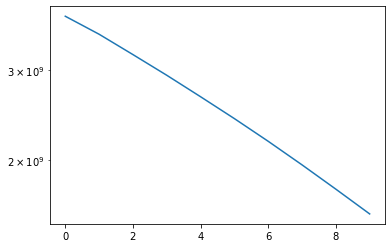

In [119]:
plt.plot(L)
plt.yscale('log')

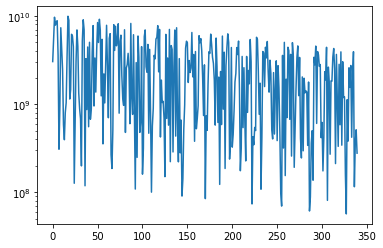

In [120]:
r = 1
plt.plot([sum(LA[i:i+r])/r for i in range(0,len(LA),r)])
plt.yscale('log')

In [121]:
##Add detail error, MSE of full image only minimizes general pixel distribution
##Add more training examples
##Add N previous and N post current inconsistence image
##Add optical flow, frequencies or other features for temporal consistency
##Different kernel sizes
##Add Gaisian Noise
##Reconstruct image with kernel middle between encoder and decofer
##Use data with less loss value, selection
##How to combine data with less error and with more error?
##Localize area and correct error

In [122]:
def Prediction(Vid,Params):
    P = []
    V = [torch.tensor(cv2.resize(i,(320,320),interpolation=cv2.INTER_AREA),
                              dtype=torch.float32).permute(2,0,1).unsqueeze(0)/255.0 for i in Vid]
    k,kt,kb = Extract(Params)
    N = len(kt)//2
    for f in range(len(V) - 2 * N):
        first, current, last = f, f + N // 2, f + N
        Pred = ObjFun(V[first:last], V[current], k, kt, kb)
        P.append(cv2.resize((Pred[0] * 255).squeeze(0).permute(1, 2, 0).detach().cpu().numpy().astype(np.uint8),
                                           (Vid[f].shape[1], Vid[f].shape[0]), interpolation=cv2.INTER_AREA))
    return P

In [123]:
Parameters = torch.load("par.pth")
cap = open_vid("AI Gen/movie(31).mp4")
Video = get_frames(cap)

In [124]:
PVid = Prediction(Video,Parameters)

In [125]:
ThroughFrames(PVid)